In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('img/style.mplstyle')

scratch_base = '/pscratch/sd/j/jrobnik/'
scratch = scratch_base + 'quasars_scratch/'
dir_data = scratch_base + 'quasars/'
dir_results = dir_data + 'data/'

def remove_failure(df, verbose= False):
    success = np.array(df['success'])
    if verbose:
        print(np.sum(success) / len(df))
    return df[df['success']]


def read_simulations(extra, test_stat):
    q = []
    num_sim = 100
    for i in range(num_sim):
        df = pd.read_csv(dir_results + '/sim_'+str(i)+'_0'+extra+'.csv').sort_values(test_stat, ascending=False)
        df = remove_failure(df)
        q.append(np.array(df[test_stat]))
    
    # because of failure removal, not all arrays have the same length, let's enforce that
    lenn = np.min([len(qq) for qq in q])
    q = np.array([qq[:lenn] for qq in q])

    return np.sort(q, axis = 0)


In [2]:
ids = np.load(dir_data + 'ids.npy)

data = pd.read_csv(dir_results + 'real_0_0.csv').sort_values('logB', ascending=False)
data1 = pd.read_csv(dir_results + 'real_1000_0.csv').sort_values('logB', ascending=False)
#data2 = pd.read_csv(dir_results + 'real_1000_0_mixture0.5.csv').sort_values('logB', ascending=False)
#data3 = pd.read_csv(dir_results + 'real_1000_0_mixture0.2.csv').sort_values('logB', ascending=False)

#data1['log_post_odds'] = data1['logB'] + data1['log_prior_odds']

data_sim = read_simulations('', 'logB')
data_sim_ls = read_simulations('', 'white_periodogram')

data = remove_failure(data, verbose= True)
data1 = remove_failure(data1, verbose= True)

info = pd.read_csv(dir_data + 'quasar_info.txt', delim_whitespace=True)
data = pd.merge(data, info, on= 'id')

0.9882712036853857
0.8428058672243733


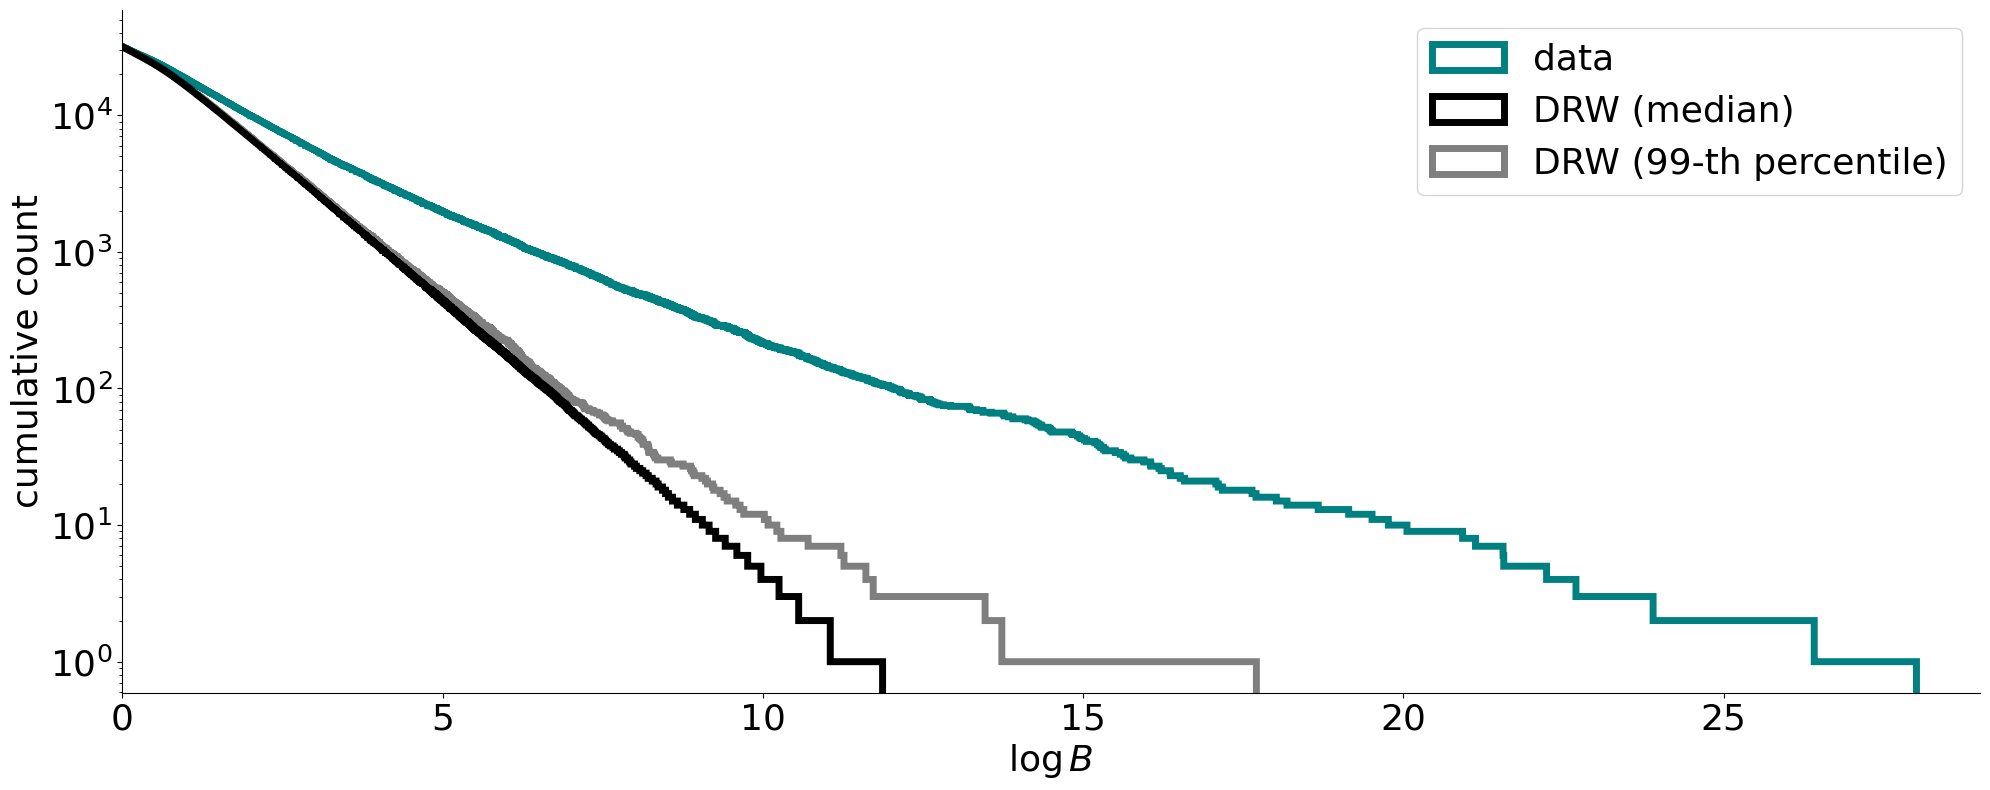

In [7]:
plt.figure(figsize= (20, 8))
ff = 26
plt.yticks(fontsize=ff)
plt.xticks(fontsize=ff)

istat = 1
stat = ['log_post_odds', 'logB', 'log_lik_ratio'][istat]
xlabel = [r'$\log \frac{P(H_1 \vert \mathrm{data})}{P(H_0 \vert \mathrm{data})}$', r'$\log B$', 'log-likelihood ratio'][istat]  
save_name = 'img/results' + ['_post_odds', '', '_loglik'][istat]  

X = [('periodic template', 'teal', 1, np.array(data[stat]) ), 
     ('null signal template', 'chocolate', 1, np.array(data1[stat]) ), 
    #  ('mixture = 0.5', 'xkcd:ruby', 1, np.array(data2[stat]) ), 
    #  ('mixture = 0.2', 'purple', 1, np.array(data3[stat]) ), 
     ('DRW (median)', 'black', 1, np.median(data_sim, axis= 0) ), 
     ('DRW (99-th percentile)', 'black', 0.5, data_sim[-1]),
     #('DRW2 (median)', 'tab:purple', 1, np.median(data_sim2, axis= 0) ), 
     #('DRW2 (90-th percentil)', 'tab:purple', 0.5, data_sim2[-1])
     ]


for name, color, alpha, x in X:
    x = x[np.isfinite(x)]
    plt.hist(x, cumulative= -1, histtype= 'step', bins = len(x), label= name, lw= 5, color = color, alpha= alpha)

plt.xlim(0, 37)
plt.legend(fontsize= ff)
plt.xlabel(xlabel, fontsize = ff)
plt.ylabel('cumulative count', fontsize= ff)
plt.yscale('log')
plt.tight_layout()
plt.savefig(save_name)

plt.show()

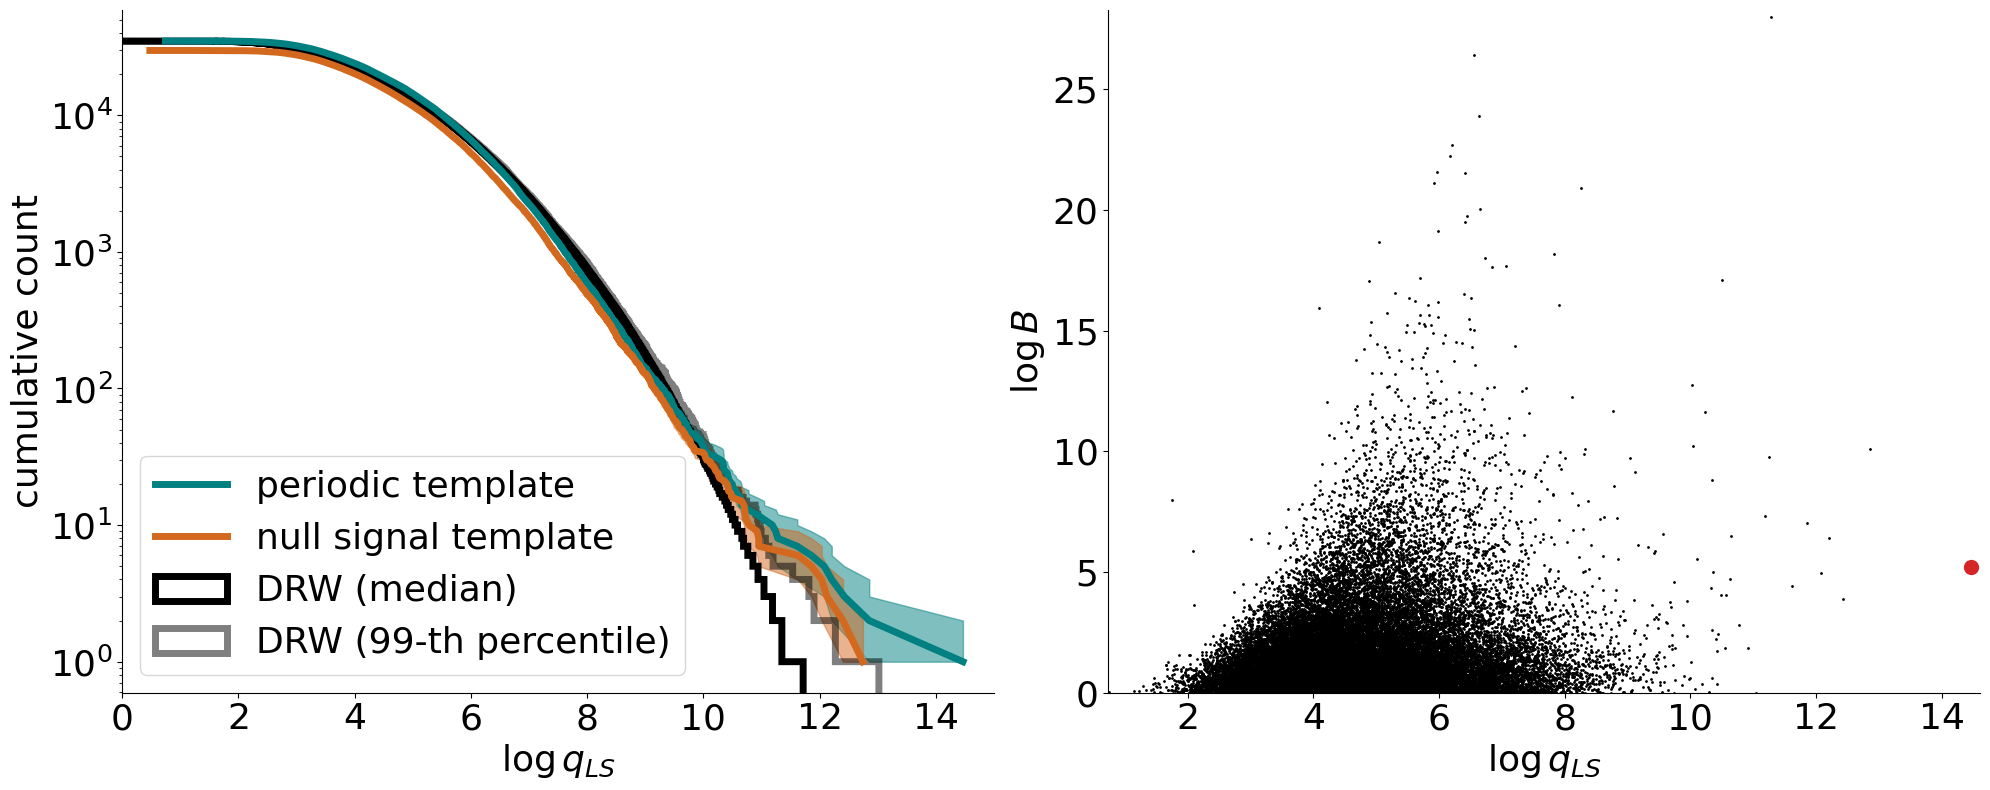

In [7]:
stat = 'white_periodogram'

X1 = [
    ('periodic template', 'teal', 1, np.array(data[stat]) ), 
    ('null signal template', 'chocolate', 1, np.array(data1[stat]) ) 
    ]
    
X2 = [
    ('DRW (median)', 'black', 1, np.median(data_sim_ls, axis= 0) ), 
    ('DRW (99-th percentile)', 'black', 0.5, data_sim_ls[-1])
    ]

from simulations.util import *

plt.figure(figsize= (20, 8))
ff = 26

plt.subplot(1, 2, 1)
plt.yticks(fontsize=ff)
plt.xticks(fontsize=ff)

for name, color, alpha, x in X1:
    x = np.log(x)#[np.isfinite(x)])
    p, x, xmin, xmax = cdf_with_err(x)
    p = np.arange(len(p)) + 1.0
    plt.plot(x, p, color = color, lw = 5, label= name)
    plt.fill_betweenx(p, xmin, xmax, color= color, alpha= 0.5)
    
for name, color, alpha, x in X2:
    x = np.log(x[np.isfinite(x)])
    x = np.concatenate((x, np.ones(2) * (-500))) # dirty trick to make cdf not show the vertical line at the left end
    plt.hist(x, cumulative= -1, histtype= 'step', bins = len(x), label= name, lw= 5, color = color, alpha= alpha)
    
plt.xlim(0, 15)
plt.legend(fontsize= ff, loc = 3)
plt.xlabel(r'$\log q_{LS}$', fontsize = ff)
plt.ylabel('cumulative count', fontsize= ff)
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.yticks(fontsize=ff)
plt.xticks(fontsize=ff)

y = np.array(data['logB'])
y = y[np.isfinite(y)]

x = np.array(data['white_periodogram'])
x = np.log(x[np.isfinite(x)])
mask = x < 14.

plt.plot(x[mask], y[mask], '.', markersize= 2, color= 'black')
plt.plot(x[~mask], y[~mask], 'o', markersize= 10, color= 'tab:red')
plt.xlabel(r'$\log q_{LS}$', fontsize= ff)
plt.ylabel(r'$\log B$', fontsize= ff)
plt.ylim(0, 1.01 * np.max(y))
plt.xlim(np.min(x) * 0.99, np.max(x) * 1.01)

plt.tight_layout()

plt.savefig('img/resultsLS.png')
plt.show()

In [8]:
# scores of the 33 Maria's candidates

ids33 = np.array(pd.read_csv('quasars/known.csv')['id'])
data[data['id'].isin(ids33)]

,logB,log_lik_ratio,white_periodogram,cycles,period,sigma,tau,A_const,A_sin,A_cos,success,data_points,T,log_prior_odds,id,redshift
198,10.225647,10.661214,23076.711879,2.328833,492.897515,0.081942,75.464433,17.781721,0.225609,0.265159,True,91,1147.875986,-2.489935,16357,0.308
254,9.718668,5.850742,3014.823218,2.624773,423.684126,0.139442,71.728010,20.093631,-0.523651,0.030869,True,53,1112.074571,-1.534502,343421,0.928
425,8.455731,9.763068,2268.107756,2.422055,456.998811,0.088206,379.507860,19.296743,0.121909,0.105280,True,68,1106.876075,1.595218,346171,0.886
749,7.147074,7.191866,1232.284482,2.877443,478.640922,0.115397,203.704907,20.519792,0.188046,0.202244,True,65,1377.262134,0.974082,284871,0.886
941,6.601957,5.646705,1512.102151,2.584907,487.725546,0.134627,41.174442,19.975701,-0.375241,0.142058,True,53,1260.724973,-0.384061,411886,0.842
996,6.468357,6.997501,486.744924,2.685290,310.491481,0.092179,48.914679,19.728633,-0.268083,0.031686,True,54,833.759642,-2.228253,424003,1.598
1359,5.827289,6.127215,1843.951442,2.660740,283.776047,0.125406,18.235711,20.100761,0.257231,0.006151,True,67,755.054224,-2.394376,376927,2.132
1739,5.279705,7.376022,1075.145507,3.589249,321.198189,0.085948,237.664127,19.546567,-0.255549,0.014160,True,52,1152.860290,-0.703353,332716,0.742
1855,5.123820,5.465361,4386.636195,2.617250,449.989698,0.172666,12.078663,19.670687,0.161995,-0.127524,True,228,1177.735685,-2.733210,57671,0.628
2265,4.710616,4.003482,1052.352823,2.576608,430.029534,0.116488,66.835185,19.943668,-0.206850,0.173691,True,53,1108.017538,0.626334,276630,2.460


366226
138084
263798
288754
316958
224111
304690
295361
294564
264967


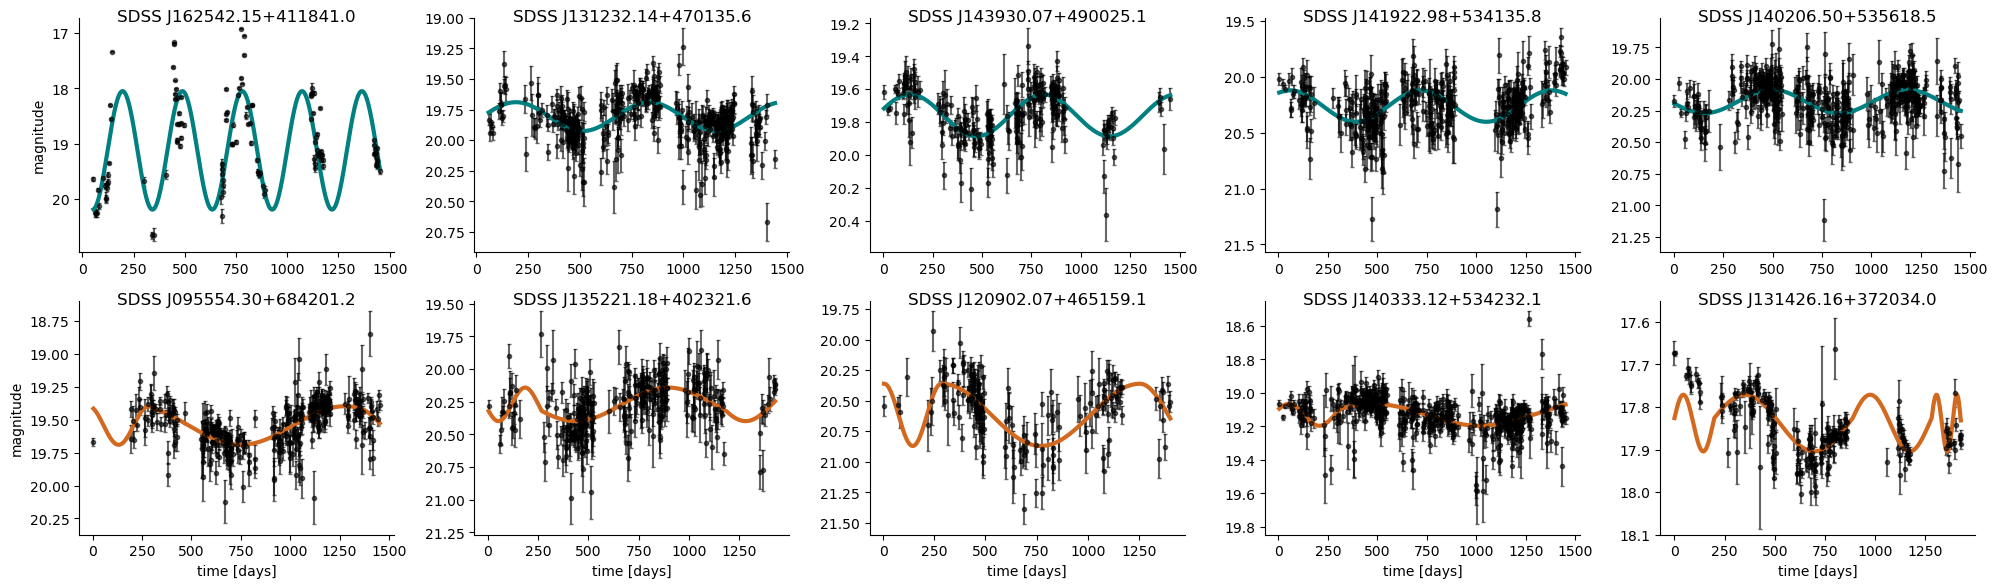

In [7]:
import jax
import jax.numpy as jnp

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True) # since we are on cpu we do not mind using 64 bits

from LombScargle import periodogram
from quasars.prep import load_data


def get_temp(temp_num, id):
    if temp_num == 0:
        return periodogram.basic
    else:
        job_id = jnp.argmin(jnp.abs(ids - id))
        key= jax.random.split(jax.random.key(42), 10 * len(ids)).reshape(10, len(ids))[temp_num][job_id]

        return periodogram.null_signal_template(key, 2000)


def plot_fit(results, temp_num):

    amp = np.array(results[['A_const', 'A_sin', 'A_cos']])
    freq_best = 1./results['period']
    id = results['id']
    time, mag, mag_err, _ = load_data(id)
    t0 = 54903.
    quasar_names = {366226: 'SDSS J162542.15+411841.0', 
                    263798: 'SDSS J131232.14+470135.6', 
                    316958: 'SDSS J143930.07+490025.1', 
                    304690: 'SDSS J141922.98+534135.8', 
                    294564: 'SDSS J140206.50+535618.5', 
                    264967: 'SDSS J131426.16+372034.0', 
                    263798: 'SDSS J131232.14+470135.6', 
                    295399: 'SDSS J140337.06+551251.3', 
                    294940: 'SDSS J140247.03+542654.9', 
                    316958: 'SDSS J143930.07+490025.1', 
                    138084: 'SDSS J095554.30+684201.2', 
                    288754: 'SDSS J135221.18+402321.6', 
                    224111: 'SDSS J120902.07+465159.1', 
                    295361: 'SDSS J140333.12+534232.1', 
                    264967: 'SDSS J131426.16+372034.0'}
    
    print(id)
    plt.title(quasar_names[id], y = 0.95)
    plt.errorbar(time-t0, mag, mag_err, fmt = '.', capsize = 1.3, alpha = 0.6, color= 'black', label= 'data')
    t = jnp.linspace(jnp.min(time), jnp.max(time), 1000)
    
    model = periodogram.fit(t, freq_best, amp, temp_func= get_temp(temp_num, id))
    plt.plot(t-t0, model, color = ['teal', 'chocolate', 'chocolate'][temp_num], lw = 3, label= 'model')
    plt.gca().invert_yaxis()

plt.figure(figsize = (20, 6))
    
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plot_fit(data.iloc[i], temp_num= 0)
    if i == 0:
        plt.ylabel('magnitude')
    plt.subplot(2, 5, i + 6)
    plot_fit(data1.iloc[i], temp_num= 1)
    plt.xlabel('time [days]')
    if i == 0:
        plt.ylabel('magnitude')
    if i == 4:
        plt.ylim(18.1, 17.55)
        
plt.tight_layout()
plt.savefig('img/candidates.png')
plt.show()

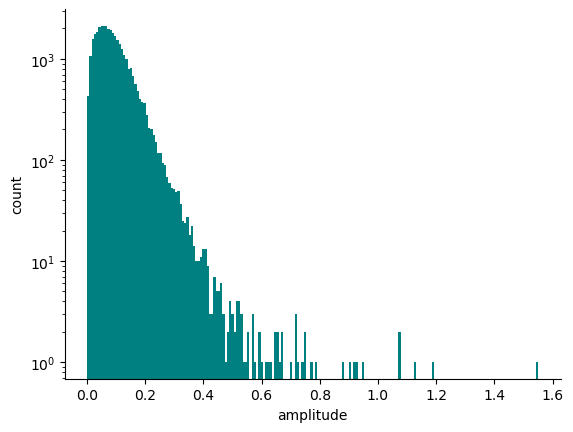

In [8]:
A = np.sqrt(np.square(data['A_cos']) + np.square(data['A_sin']))
plt.hist(A, bins = 200)
plt.yscale('log')
plt.xlabel('amplitude')
plt.ylabel('count')
plt.show()

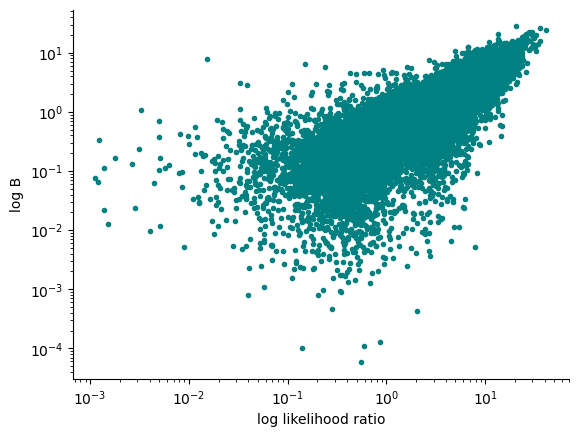

In [16]:
mask = np.isfinite(data['logB']) & (data['logB'] > 0.) #& (data['log_lik_ratio'] > 0.)
plt.plot(np.array(data['log_lik_ratio'])[mask], np.array(data['logB'])[mask], '.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log likelihood ratio')
#plt.xlim(1e-3, 100.)
plt.ylabel('log B')

plt.show()

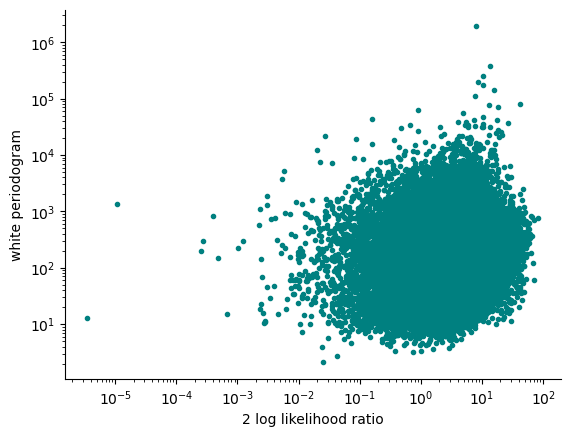

In [11]:
plt.plot(2 * np.array(data['log_lik_ratio']), np.array(data['white_periodogram']), '.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('2 log likelihood ratio')
plt.ylabel('white periodogram')
plt.show()

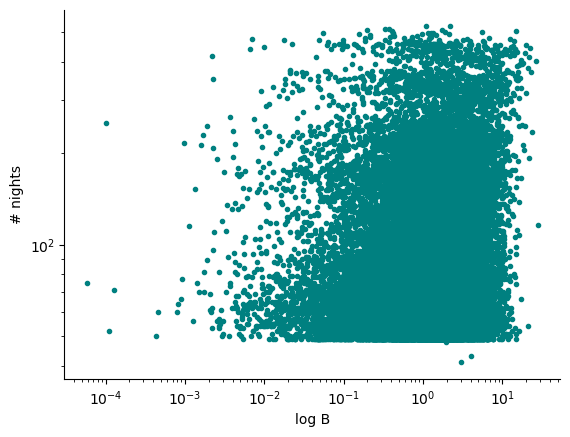

In [15]:
plt.plot(np.array(data['logB']), np.array(data['data_points']), '.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('log B')
plt.ylabel('# nights')
plt.show()

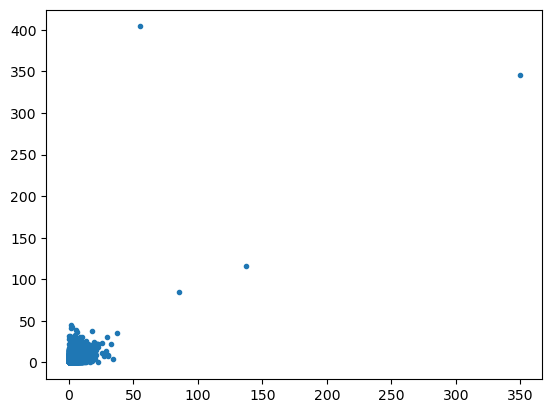

In [4]:
# are the same quasars detected on null and periodic?

data_both = data.merge(data2, on= 'id')
mask = np.isfinite(data_both['logB_x']) & np.isfinite(data_both['logB_y']) & (data_both['logB_x'] > 0) & (data_both['logB_y'] > 0)
plt.plot(np.array(data_both['logB_x'])[mask], np.array(data_both['logB_y'])[mask], '.')